In [0]:
import gym
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from collections import deque

In [0]:
env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [0]:
class Policy(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super(Policy, self).__init__()
    self.hidden_size = hidden_size
    self.layer1 = nn.Linear(state_size, hidden_size)
    self.lstm = nn.LSTM(hidden_size, action_size)
    #self.layer2 = nn.Linear(hidden_size, action_size)
    
  def forward(self, x, hidden):
      
    x = F.relu(self.layer1(x))
    x = x.view(-1, 1, self.hidden_size)
    x, hidden_out = self.lstm(x, hidden)
    x = F.softmax(x, dim=2)
    #x = F.softmax(self.layer2(x), dim=1)
    
    dist = Categorical(x)
    actions = dist.sample()
    logprobs = dist.log_prob(actions)
    
    return actions, logprobs, dist, hidden_out

In [0]:
def calc_discounted_rewards(rewards, final_state):
  R = 0
  discounted = []
  
  for idx in reversed(range(len(rewards))):
    R = rewards[idx] + R * gamma * final_state[idx]
    discounted.insert(0,R)
  return discounted

def optimize_policy(logprobs, rewards, dones, entropy):
  logprobs = torch.cat(logprobs)
  entropy = torch.cat(entropy)
  
  discounted_rewards = torch.FloatTensor(calc_discounted_rewards(rewards, dones)).unsqueeze(1)
  
  loss = (-logprobs * (discounted_rewards)).sum() + entropy.mean()*0.01   # - discounted_rewards.mean()
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.detach().numpy()
  

Policy(
  (layer1): Linear(in_features=4, out_features=96, bias=True)
  (lstm): LSTM(96, 2)
)
Episode: 500 | Reward: 200.0 | loss: 6534.3583984375

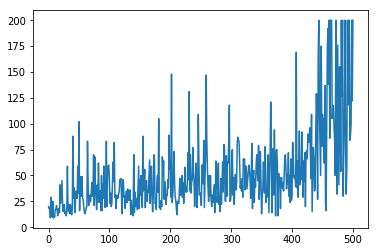

In [198]:
import copy
torch.manual_seed(1)
env.seed(1)

gamma = 0.99
lr = 1e-3
hidden_size = 96
policy = Policy(state_size, action_size, hidden_size=hidden_size)
optimizer = optim.Adam(params=policy.parameters(), lr=lr)
print(policy)
old_policy = copy.deepcopy(policy)


rewards = []
losses = []
max_epochs = 500
max_steps = 100

for ep in range(max_epochs+1):
  logprob_batch = []
  reward_batch = []
  dones_batch = []
  entropy_batch = []
  
  ep_reward = 0
  
  state = env.reset()
  hidden_out = (torch.zeros((1,1,action_size), dtype=torch.float),torch.zeros((1,1,action_size), dtype=torch.float))
  done = False
  while not done:
    hidden_in = hidden_out
    state = torch.from_numpy(state).float().unsqueeze(0)
    action, logprob, dist, hidden_out = policy(state, hidden_in)

    next_state, reward, done, _ = env.step(action.item())
    entropy = dist.entropy()
    
    logprob_batch.append(logprob)
    reward_batch.append(reward)
    dones_batch.append(1-done)
    entropy_batch.append(entropy)
    
    ep_reward += reward
    state = next_state
    
    if done:
      break
      
  rewards.append(ep_reward)
  loss_ = optimize_policy(logprob_batch, reward_batch, dones_batch, entropy_batch)
  print("\rEpisode: {} | Reward: {} | loss: {}".format(ep, ep_reward, loss_), end="", flush=True)
  losses.append(loss_)
    
    
plt.plot(rewards)
#plt.plot(losses)
plt.show()

In [167]:
for params in old_policy.parameters():
  print(params)

Parameter containing:
tensor([[-0.3371, -0.3591, -0.3952, -0.4890],
        [ 0.1308, -0.0853,  0.2618,  0.3837],
        [ 0.3579, -0.2191,  0.3337,  0.1765],
        ...,
        [ 0.3491,  0.2982,  0.0475,  0.2848],
        [-0.2607,  0.3335,  0.2593,  0.2649],
        [-0.4735, -0.3829, -0.3258,  0.4572]], requires_grad=True)
Parameter containing:
tensor([ 0.0900,  0.1191,  0.2031,  0.3596,  0.2550, -0.3406,  0.2048, -0.0954,
         0.1743,  0.1786, -0.4699,  0.4763,  0.3522, -0.3863,  0.1857,  0.0858,
         0.3400,  0.0729, -0.0595, -0.4026, -0.0460, -0.4907, -0.4970, -0.2798,
        -0.2844, -0.4988, -0.0309,  0.1910, -0.0407,  0.0565,  0.0512, -0.1051,
        -0.0515, -0.4221, -0.3530, -0.2630,  0.4238,  0.0987,  0.2134, -0.4759,
        -0.0477, -0.3905, -0.3357,  0.3211, -0.4055,  0.4154, -0.2567,  0.4061,
        -0.4410, -0.0756, -0.4979,  0.3683, -0.1940, -0.4649, -0.1122,  0.0465,
         0.1741,  0.1087,  0.4182,  0.1635, -0.1553, -0.3249,  0.2674, -0.2595,
      

In [138]:
for param in policy.parameters():
  print(param)

Parameter containing:
tensor([[ 0.2973, -0.1233, -0.3587, -0.3869],
        [ 0.0875, -0.5115,  0.4294,  0.5518],
        [-0.4158, -0.2628, -0.1055, -0.5726],
        [ 0.1618,  0.4761,  0.1599, -0.1560],
        [-0.1244, -0.4022, -0.0931,  0.2386],
        [-0.2152,  0.1796, -0.0302,  0.0508],
        [-0.0939, -0.4849, -0.6826, -0.5460],
        [ 0.1821, -0.3976,  0.0651,  0.3202],
        [-0.0487,  0.0269,  0.6378,  0.4938],
        [-0.2124,  0.3482, -0.2230,  0.4323],
        [-0.0298, -0.3088, -0.4573, -0.3071],
        [-0.0857, -0.3932,  0.4768,  0.4100],
        [ 0.3496,  0.1241,  0.0723, -0.5943],
        [-0.0369,  0.4099,  0.0222, -0.0023],
        [-0.3037, -0.1974, -0.2844, -0.4483],
        [ 0.3288,  0.1932, -0.3506, -0.4518],
        [ 0.1714, -0.4437, -0.5661, -0.4858],
        [ 0.3319,  0.0932,  0.4537,  0.3530],
        [ 0.4553,  0.4311,  0.5989,  0.3239],
        [-0.4503,  0.2662,  0.1715,  0.3036],
        [-0.4429,  0.1804,  0.3056, -0.2337],
        [ 0.